## Mr.HelpMate AI

In [142]:
# !pip install pdfplumber
# !pip install tiktoken
# !pip install openai
# !pip install chromaDB
# !pip install sentence-transformers
# !pip install pandas

In [1]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [2]:
# Define the path of the PDF
single_pdf_path = 'Principal-Sample-Life-Insurance-Policy.pdf'

In [3]:
## Reading PDF file

In [10]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[45]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

PART IV - BENEFITS
Section A - Member Life Insurance
Article 1 - Schedule of Insurance
Subject to the Effective Date provisions of PART III, Section B, and the qualifying provisions of
this Section A, the Scheduled Benefit for an insured Member will be based on his or her class:
Class *Scheduled Benefit
ALL MEMBERS $10,000
However, if a Member has received any payments under the Accelerated Benefits provision as
described in Section A, Article 7, the Scheduled Benefit will be reduced by the amount of such
payment.
*The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART
III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of
insurance approved by The Principal may be different than the Scheduled Benefit. If the
approved amount of insurance is different than the Scheduled Benefit, the approved amount will
apply.
For the age(s) shown below, the amount of a Member's insurance will be the percentage of the
Scheduled Bene

In [13]:
tables

[]

In [14]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [15]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [17]:
# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(single_pdf_path)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
extracted_text_df['Document Name'] = single_pdf_path

In [18]:
extracted_text_df

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [20]:
# Check one of the extracted page texts to ensure that the text has been correctly read

# insurance_pdfs_data.Page_Text[212]
extracted_text_df.iloc[15]['Page_Text']

"PART II - POLICY ADMINISTRATION Section A - Contract Article 1 - Entire Contract This Group Policy, the current Certificate, the attached Policyholder application, and any Member applications make up the entire contract. The Principal is obligated only as provided in this Group Policy and is not bound by any trust or plan to which it is not a signatory party. Article 2 - Policy Changes Insurance under this Group Policy runs annually to the Policy Anniversary, unless sooner terminated. No agent, employee, or person other than an officer of The Principal has authority to change this Group Policy, and, to be effective, all such changes must be in Writing and Signed by an officer of The Principal. The Principal reserves the right to change this Group Policy as follows: a. Any or all provisions of this Group Policy may be amended or changed at any time, including retroactive changes, to the extent necessary to meet the requirements of any law or any regulation issued by any governmental ag

In [29]:
life_insurance_df = extracted_text_df.copy()

In [30]:
life_insurance_df['Text_length'] = life_insurance_df['Page_Text'].apply(lambda x: len(x.split(" ")))

In [31]:
life_insurance_df

,Page No.,Page_Text,Document Name,Text_length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
...,...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf,285
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf,418
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf,322
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5


In [32]:
# Retain only the rows with a text length of at least 10
life_insurance_df = life_insurance_df[life_insurance_df.Text_length >=20]

In [34]:
life_insurance_df.head()

,Page No.,Page_Text,Document Name,Text_length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176


In [35]:
# Store the metadata for each page in a separate column

life_insurance_df['Metadata'] = life_insurance_df.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

/var/folders/_t/zvghdz9d6wq3453ltv1zgrf80000gn/T/ipykernel_40421/2198668485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  life_insurance_df['Metadata'] = life_insurance_df.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [36]:
life_insurance_df.head()

,Page No.,Page_Text,Document Name,Text_length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:

1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

### Generate and Store Embeddings using OpenAI and ChromaDB

In [37]:
from sentence_transformers import SentenceTransformer, util
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

In [48]:
def generate_embeddings(texts):
    embedding = model.encode(texts)
    return embedding

In [49]:
def generate_embeddings_on_df(df):
    df['Embeddings'] = df['Page_Text'].apply(lambda x:generate_embeddings(x))

In [50]:
# Create embeddings for 'Chunk Text' column on all three dataframes

generate_embeddings_on_df(life_insurance_df)

/var/folders/_t/zvghdz9d6wq3453ltv1zgrf80000gn/T/ipykernel_40421/989742603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Embeddings'] = df['Page_Text'].apply(lambda x:generate_embeddings(x))


In [51]:
life_insurance_df.head()

,Page No.,Page_Text,Document Name,Text_length,Metadata,Embeddings
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.025921933, 0.047777504, 0.055857737, 0.042..."
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.105795726, -0.000530206, 0.016577577, -0.0..."
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.06354085, 0.058701582, 0.07262771, -0.0272..."
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.05122388, 0.025714057, 0.037129402, -0.042..."
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.06796547, 0.006616177, 0.055948876, 0.0179..."


In [55]:
type(life_insurance_df.iloc[0]['Embeddings'])

numpy.ndarray

In [61]:
# Reading OpenAI key
with open("../../OpenAI_API_Key.txt","r") as f:
    openai.api_key = "".join(f.readlines())

In [63]:
# openai.api_key

In [64]:
# importing chromadb
import chromadb

client = chromadb.PersistentClient()
life_insurance_collection = client.get_or_create_collection(name="Life_Insurance_Collection")


In [65]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

life_insurance_collection.add(
    documents= life_insurance_df['Page_Text'].to_list(),
    ids = [str(i) for i in range(0, len(life_insurance_df))],
    metadatas = life_insurance_df['Metadata'].to_list()
)

In [66]:
life_insurance_collection.peek()

{'ids': ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17'],
 'embeddings': [[-0.025921909138560295,
   0.04777759686112404,
   0.05585768446326256,
   0.04239744320511818,
   0.058143023401498795,
   0.10849819332361221,
   0.028891023248434067,
   -0.009777775965631008,
   -0.08766447752714157,
   0.027251580730080605,
   0.037737857550382614,
   0.041594937443733215,
   -0.01369894202798605,
   -0.06046949699521065,
   -0.09530660510063171,
   -0.0355200357735157,
   -0.05023419111967087,
   0.01387760229408741,
   -0.03827238827943802,
   0.03651926666498184,
   0.009495573118329048,
   0.03799033910036087,
   -0.061914920806884766,
   -0.03339469060301781,
   0.032034922391176224,
   0.0003444863250479102,
   0.03497112914919853,
   -0.04820385202765465,
   0.021832747384905815,
   0.00023780166520737112,
   0.004617250058799982,
   -0.03627116605639458,
   -0.034943681210279465,
   0.04148409143090248,
   0.033913504332304,
   -0.008206113241612911,
   -0.04822536185383797

### Implementing cache collection


In [68]:
cache_collection = client.get_or_create_collection(name="cache_collection")

In [123]:
# Read the user query

query = input()

 What are the proof of disability?


In [124]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 10 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [125]:
cache_results

{'ids': [['What are the conditions for termination of fraud?']],
 'distances': [[1.4302178821848335]],
 'metadatas': [[{'distances0': '1.0538243868913528',
    'distances1': '1.1062258275893644',
    'distances2': '1.128163113484455',
    'distances3': '1.1628474099348556',
    'distances4': '1.188996465511411',
    'distances5': '1.2408653667627272',
    'distances6': '1.249776216823728',
    'distances7': '1.2775570276740962',
    'distances8': '1.2845227819889555',
    'documents0': "A Member's insurance under this Group Policy for a Dependent will terminate on the earliest of: a. the date his or her Member Life Insurance ceases; or b. the date Dependent Life Insurance is removed from this Group Policy; or c. the date the last premium is paid for the Member's Dependent Life Insurance; or d. any date desired, if requested by the Member before that date; or e. the date the Member ceases to be in a class for which Dependent Life Insurance is provided; or f. for a Dependent spouse on th

In [126]:
results = life_insurance_collection.query(
query_texts=query,
n_results=10
)
# results.items()
results

{'ids': [['48', '46', '47', '5', '51', '53', '14', '10', '15', '11']],
 'distances': [[0.8868219902054606,
   1.004631339124136,
   1.0782386199106497,
   1.085378815781815,
   1.1063756716551376,
   1.1778383457521133,
   1.2268223793147586,
   1.2558990426745562,
   1.2800406580963475,
   1.3033112250183359]],
 'metadatas': [[{'Page_No.': 'Page 51',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 49',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 50',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 8',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 54',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 56',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 17',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 13',
    'Policy_Name': 'Prin

In [127]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = life_insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(9):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Not found in cache. Found in main collection.


In [128]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 51', 'Policy_Name': 'Princi...",Coverage During Disability will cease on the e...,0.886822,48
1,"{'Page_No.': 'Page 49', 'Policy_Name': 'Princi...",Payment of benefits will be subject to the Ben...,1.004631,46
2,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi...",The Principal may require that a ADL Disabled ...,1.078239,47
3,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip...",Section A - Member Life Insurance Schedule of ...,1.085379,5
4,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...","f . claim requirements listed in PART IV, Sect...",1.106376,51
5,"{'Page_No.': 'Page 56', 'Policy_Name': 'Princi...","If a Member sustains an injury, and as a resul...",1.177838,53
6,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,1.226822,14
7,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,1.255899,10
8,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",c . a copy of the form which contains the stat...,1.280041,15
9,"{'Page_No.': 'Page 14', 'Policy_Name': 'Princi...",c . end stage renal failure; or d. acquired im...,1.303311,11


### Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.


<br>

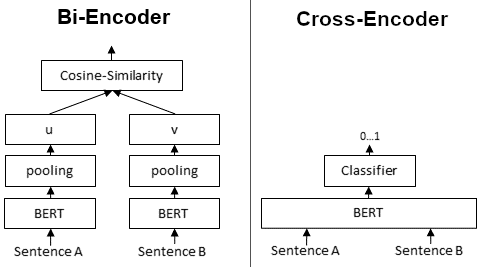

<br>


In [129]:
from sentence_transformers import CrossEncoder, util

In [130]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [131]:

# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [132]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [133]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 51', 'Policy_Name': 'Princi...",Coverage During Disability will cease on the e...,0.886822,48,-1.141582
1,"{'Page_No.': 'Page 49', 'Policy_Name': 'Princi...",Payment of benefits will be subject to the Ben...,1.004631,46,-1.073195
2,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi...",The Principal may require that a ADL Disabled ...,1.078239,47,-1.150185
3,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip...",Section A - Member Life Insurance Schedule of ...,1.085379,5,-7.156521
4,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...","f . claim requirements listed in PART IV, Sect...",1.106376,51,-8.463350
5,"{'Page_No.': 'Page 56', 'Policy_Name': 'Princi...","If a Member sustains an injury, and as a resul...",1.177838,53,-9.579155
6,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,1.226822,14,-6.927052
7,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,1.255899,10,-8.354084
8,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",c . a copy of the form which contains the stat...,1.280041,15,-10.413887
9,"{'Page_No.': 'Page 14', 'Policy_Name': 'Princi...",c . end stage renal failure; or d. acquired im...,1.303311,11,-5.942042


In [134]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 51', 'Policy_Name': 'Princi...",Coverage During Disability will cease on the e...,0.886822,48,-1.141582
1,"{'Page_No.': 'Page 49', 'Policy_Name': 'Princi...",Payment of benefits will be subject to the Ben...,1.004631,46,-1.073195
2,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi...",The Principal may require that a ADL Disabled ...,1.078239,47,-1.150185


In [135]:
query

'What are the proof of disability?'

In [136]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
1,"{'Page_No.': 'Page 49', 'Policy_Name': 'Princi...",Payment of benefits will be subject to the Ben...,1.004631,46,-1.073195
0,"{'Page_No.': 'Page 51', 'Policy_Name': 'Princi...",Coverage During Disability will cease on the e...,0.886822,48,-1.141582
2,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi...",The Principal may require that a ADL Disabled ...,1.078239,47,-1.150185


In [137]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
1,Payment of benefits will be subject to the Ben...,"{'Page_No.': 'Page 49', 'Policy_Name': 'Princi..."
0,Coverage During Disability will cease on the e...,"{'Page_No.': 'Page 51', 'Policy_Name': 'Princi..."
2,The Principal may require that a ADL Disabled ...,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi..."


### 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.m

In [138]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [139]:
response = generate_response(query, top_3_RAG)

In [140]:
# Print the response

print("\n".join(response))

The proof of disability required for claiming benefits may vary depending on the specific policy terms. In the provided insurance documents, there is mention of "ADL Disabled." This likely refers to Activities of Daily Living (ADL) disability criteria, commonly used to assess disability for insurance purposes. Specific ADLs often include tasks like dressing, bathing, eating, toileting, transferring, and continence.

Furthermore, the document mentions that the Principal may require proof related to ADL disability, indicating that proof of disability may involve documentation or assessments related to the individual's limitations in performing these daily activities.

For detailed information on proof of disability and any specific requirements, it is recommended to refer to the relevant policy documents, particularly the sections mentioning ADL Disabled criteria.

Citations:
- Policy Name: Principal [Policy Name]
- Page Number: Page 50


In [141]:
# top_3_RAG.iloc[0]['Documents']